In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Add src directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the aggregation function from utils script
from src.utils import aggregate_interview_sequences

from src.data_loader import load_androids_corpus
from src.foundation_model_extractor import extract_wav2vec2_sequences

In [2]:
# Extract and Prepare All Sequence Data for DL Models
# Load metadata and extract clip-level sequences
BASE_DATA_PATH = 'E:/Dissertation_Data/Androids-Corpus' # Verify this path
print("Loading corpus metadata...")
reading_df, interview_df = load_androids_corpus(BASE_DATA_PATH, verbose=False)
participant_metadata = reading_df[['unique_participant_id', 'label', 'fold']].drop_duplicates().reset_index(drop=True)

SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'
SEQUENCES_INTERVIEW_CLIPS_PATH = '../data/Processed_Features/features_wav2vec2_sequences_interview_clips.pkl'

# Run extraction for interview clips if the file doesn't already exist
if not os.path.exists(SEQUENCES_INTERVIEW_CLIPS_PATH):
    print("Extracting sequential embeddings for all interview clips...")
    interview_clip_sequences = extract_wav2vec2_sequences(interview_df)
    if interview_clip_sequences:
        print(f"Saving interview clip sequences to: {SEQUENCES_INTERVIEW_CLIPS_PATH}")
        with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'wb') as f: pickle.dump(interview_clip_sequences, f)
else:
    print(f"Interview clip sequences already exist. Loading from file.")

# Load all necessary sequence data
with open(SEQUENCES_READING_PATH, 'rb') as f: reading_sequences = pickle.load(f)
with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'rb') as f: interview_clip_sequences = pickle.load(f)
print(f"\nLoaded {len(reading_sequences)} Reading sequences and {len(interview_clip_sequences)} Interview clip sequences.")

# Aggregate interview clips into session-level sequences using the util function
interview_session_sequences = aggregate_interview_sequences(interview_clip_sequences, interview_df)
print(f"Aggregated clips for {len(interview_session_sequences)} participants.")

# Create the final Reading, Interview, and Combined datasets
# Remap reading sequences to be keyed by participant ID for consistency
reading_participant_map = reading_df.set_index('filename')['unique_participant_id']
reading_session_sequences = {reading_participant_map[fname]: seq for fname, seq in reading_sequences.items() if fname in reading_participant_map.index}

# Create combined sequences by concatenating reading and interview sequences
combined_session_sequences = {}
for participant_id in tqdm(participant_metadata['unique_participant_id'], desc="Creating Combined Sequences"):
    reading_seq = reading_session_sequences.get(participant_id)
    interview_seq = interview_session_sequences.get(participant_id)
    if reading_seq is not None and interview_seq is not None:
        combined_session_sequences[participant_id] = np.vstack([reading_seq, interview_seq])

# Store all prepared sequence sets in a final dictionary
sequence_sets = {
    'reading': reading_session_sequences,
    'interview': interview_session_sequences,
    'combined': combined_session_sequences
}
print("\n--- All sequence datasets are now prepared and ready for training ---")

Loading corpus metadata...
Successfully loaded 112 Read task and 116 Interview task fold assignments.
Interview clip sequences already exist. Loading from file.

Loaded 111 Reading sequences and 857 Interview clip sequences.

Aggregating interview clips into single sequences per participant...


Aggregating Sequences: 0it [00:00, ?it/s]

Aggregated clips for 114 participants.


Creating Combined Sequences:   0%|          | 0/111 [00:00<?, ?it/s]


--- All sequence datasets are now prepared and ready for training ---


In [3]:
# Load or Extract Reading Task Sequences

# Define the path to the reading task sequences file
SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'

# Check if the file exists before running extraction
if not os.path.exists(SEQUENCES_READING_PATH):
    print("Reading task sequences not found. Running extraction...")
    
    # Check if the reading_df DataFrame is loaded
    if 'reading_df' in locals():
        print("\nExtracting sequential embeddings for the Reading Task...")
        
        # Call the extractor function
        reading_sequences = extract_wav2vec2_sequences(reading_df)
        
        # Save the new sequences to the pickle file
        if reading_sequences:
            print(f"Saving new reading task sequences to: {SEQUENCES_READING_PATH}")
            with open(SEQUENCES_READING_PATH, 'wb') as f:
                pickle.dump(reading_sequences, f)
            print("Extraction and saving complete.")
    else:
        print("ERROR: 'reading_df' not found. Cannot run extraction.")
else:
    print(f"Reading task sequences already exist. Loading from file: {SEQUENCES_READING_PATH}")

# Load the data regardless of whether it was just created or already existed
try:
    with open(SEQUENCES_READING_PATH, 'rb') as f:
        reading_sequences = pickle.load(f)
    
    print(f"\nSuccessfully loaded data for {len(reading_sequences)} reading files.")
    
    # Final Verification
    first_filename = list(reading_sequences.keys())[0]
    first_sequence = reading_sequences[first_filename]
    print(f"Verified sequence shape for '{first_filename}': {first_sequence.shape}")

except FileNotFoundError:
    print(f"ERROR: Could not load reading sequences from {SEQUENCES_READING_PATH}")

Reading task sequences already exist. Loading from file: ../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl

Successfully loaded data for 111 reading files.
Verified sequence shape for '01_CF56_1.wav': (4378, 768)


In [5]:
# Run Tuned CNN-LSTM Experiments for All Data Types

# Import the NEW function
from src.dl_cv_strategies import run_pytorch_nested_cv_with_optuna

# Dictionary to store the results of the tuned DL experiments
tuned_dl_results = {}

# Define experiment parameters
N_TRIALS = 25      # Number of hyperparameter sets to try in each outer fold
N_EPOCHS = 50      # Maximum number of epochs for the final model training in each fold
PATIENCE = 10      # Patience for early stopping
BATCH_SIZE = 8

# Loop through the three prepared sequence sets
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
    
    if not os.path.exists(results_save_path):
        print(f"\n--- Running experiment: {experiment_name.upper()} ---")
        
        # Filter metadata for participants in the current dataset
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Run the full nested CV with Optuna tuning
        tuned_results_df, tuned_predictions = run_pytorch_nested_cv_with_optuna(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            n_trials=N_TRIALS,
            epochs=N_EPOCHS,
            patience=PATIENCE,
            batch_size=BATCH_SIZE
        )
        
        # Save results for this experiment
        results_to_save = {'results_df': tuned_results_df, 'predictions': tuned_predictions}
        with open(results_save_path, 'wb') as f:
            pickle.dump(results_to_save, f)
        print(f"Results saved to {results_save_path}")
        tuned_dl_results[experiment_name] = results_to_save
    else:
        print(f"\nLoading pre-computed results for {experiment_name.upper()}")
        with open(results_save_path, 'rb') as f:
            tuned_dl_results[experiment_name] = pickle.load(f)

print("\n--- All Tuned Deep Learning experiments are now complete ---")


Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_READING

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_INTERVIEW

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_COMBINED

--- All Tuned Deep Learning experiments are now complete ---


In [ ]:
# Train and Save the Best Model for Each Data Type with Early Stopping

from sklearn.model_selection import StratifiedKFold
from src.dl_cv_strategies import SequenceDataset, collate_fn, _train_eval_loop
from torch.utils.data import DataLoader
import torch
from src.models import CNNLSTM
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# This dictionary stores the loss histories for plotting
final_model_histories = {}

# Create a canonical metadata DataFrame with all participants
# Ensures labels present for all participants, regardless of which task they completed.
full_metadata = pd.concat([
    reading_df[['unique_participant_id', 'label']],
    interview_df[['unique_participant_id', 'label']]
]).drop_duplicates().reset_index(drop=True)

# Loop through each of our three core data types
for data_type in ['reading', 'interview', 'combined']:
    
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{data_type}'
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    if os.path.exists(MODEL_SAVE_PATH):
        print(f"Final model for '{data_type}' already exists. Skipping.")
        saved_data = torch.load(MODEL_SAVE_PATH)
        if 'train_loss_history' in saved_data:
            final_model_histories[data_type] = {
                'train': saved_data['train_loss_history'],
                'val': saved_data['val_loss_history']
            }
        continue

    print(f"\n--- Preparing to train final model for: {data_type.upper()} ---")

    try:
        results_df = tuned_dl_results[experiment_name]['results_df']
        best_fold_params = results_df.loc[results_df['f1_score'].idxmax()]['best_params']
        print(f"Found best hyperparameters for '{data_type}':\n{best_fold_params}")

        # Prepare the full dataset for final training
        full_sequences_dict = sequence_sets[data_type]
        participants_for_final_model = list(full_sequences_dict.keys())
        
        # Use complete metadata for label mapping
        metadata_for_final_model = full_metadata[full_metadata['unique_participant_id'].isin(participants_for_final_model)]
        label_map_final = metadata_for_final_model.set_index('unique_participant_id')['label'].apply(lambda x: 1 if x == 'Patient' else 0)
        
        final_sequences = [full_sequences_dict[pid] for pid in participants_for_final_model]
        final_labels = label_map_final.loc[participants_for_final_model].values
        
        X_final = np.array(final_sequences, dtype=object)
        y_final = np.array(final_labels)

        # 90/10 train/validation split for early stopping
        final_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        final_train_idx, final_val_idx = next(final_splitter.split(X_final, y_final))
        
        X_train_final, X_val_final = X_final[final_train_idx], X_final[final_val_idx]
        y_train_final, y_val_final = y_final[final_train_idx], y_final[final_val_idx]

        final_train_dataset = SequenceDataset(X_train_final, y_train_final)
        final_val_dataset = SequenceDataset(X_val_final, y_val_final)
        
        final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        # Build and train the final model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        final_model = CNNLSTM(
            input_dim=final_sequences[0].shape[1],
            dropout_rate=best_fold_params['dropout_rate'],
            cnn_out_channels=best_fold_params['cnn_out_channels'],
            lstm_hidden_dim=best_fold_params['lstm_hidden_dim'],
            activation_fn=best_fold_params['activation_fn']
        ).to(device)
        
        optimizer = torch.optim.Adam(final_model.parameters(), lr=best_fold_params['learning_rate'])
        loss_fn = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

        FINAL_TRAINING_EPOCHS = 100
        print(f"\nTraining final model for '{data_type}' for up to {FINAL_TRAINING_EPOCHS} epochs...")
        
        best_final_model, train_history, val_history = _train_eval_loop(
            final_model, final_train_loader, final_val_loader, loss_fn, 
            optimizer, scheduler, device, FINAL_TRAINING_EPOCHS, PATIENCE
        )
        
        print("Final training complete.")

        # Save the final artefact
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
        torch.save({
            'hyperparameters': best_fold_params,
            'model_state_dict': best_final_model.state_dict(),
            'train_loss_history': train_history,
            'val_loss_history': val_history
        }, MODEL_SAVE_PATH)
        print(f"Final model and histories for '{data_type}' saved to: {MODEL_SAVE_PATH}")

    except KeyError:
        print(f"Could not find tuned results for '{experiment_name}'. Skipping final model training.")
    except Exception as e:
        print(f"An error occurred during final model training for '{data_type}': {e}")

print("\n--- All final models have been trained and saved. ---")


--- Preparing to train final model for: READING ---
Found best hyperparameters for 'reading':
{'learning_rate': 8.831608343216576e-05, 'dropout_rate': 0.48481256445096776, 'cnn_out_channels': 32, 'lstm_hidden_dim': 64, 'activation_fn': 'silu'}

Training final model for 'reading' for up to 100 epochs...
  > Early stopping triggered at epoch 46
Final training complete.
Final model and histories for 'reading' saved to: ../models/final_tuned_cnn_lstm_reading.pt

--- Preparing to train final model for: INTERVIEW ---
Found best hyperparameters for 'interview':
{'learning_rate': 7.283660175885175e-05, 'dropout_rate': 0.4713317142238612, 'cnn_out_channels': 128, 'lstm_hidden_dim': 128, 'activation_fn': 'silu'}

Training final model for 'interview' for up to 100 epochs...
  > Early stopping triggered at epoch 63
Final training complete.
Final model and histories for 'interview' saved to: ../models/final_tuned_cnn_lstm_interview.pt

--- Preparing to train final model for: COMBINED ---
Found bes

--- Generating Training/Validation Loss Curves for Final Models ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_17660\1826920770.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(MODEL_SAVE_PATH)


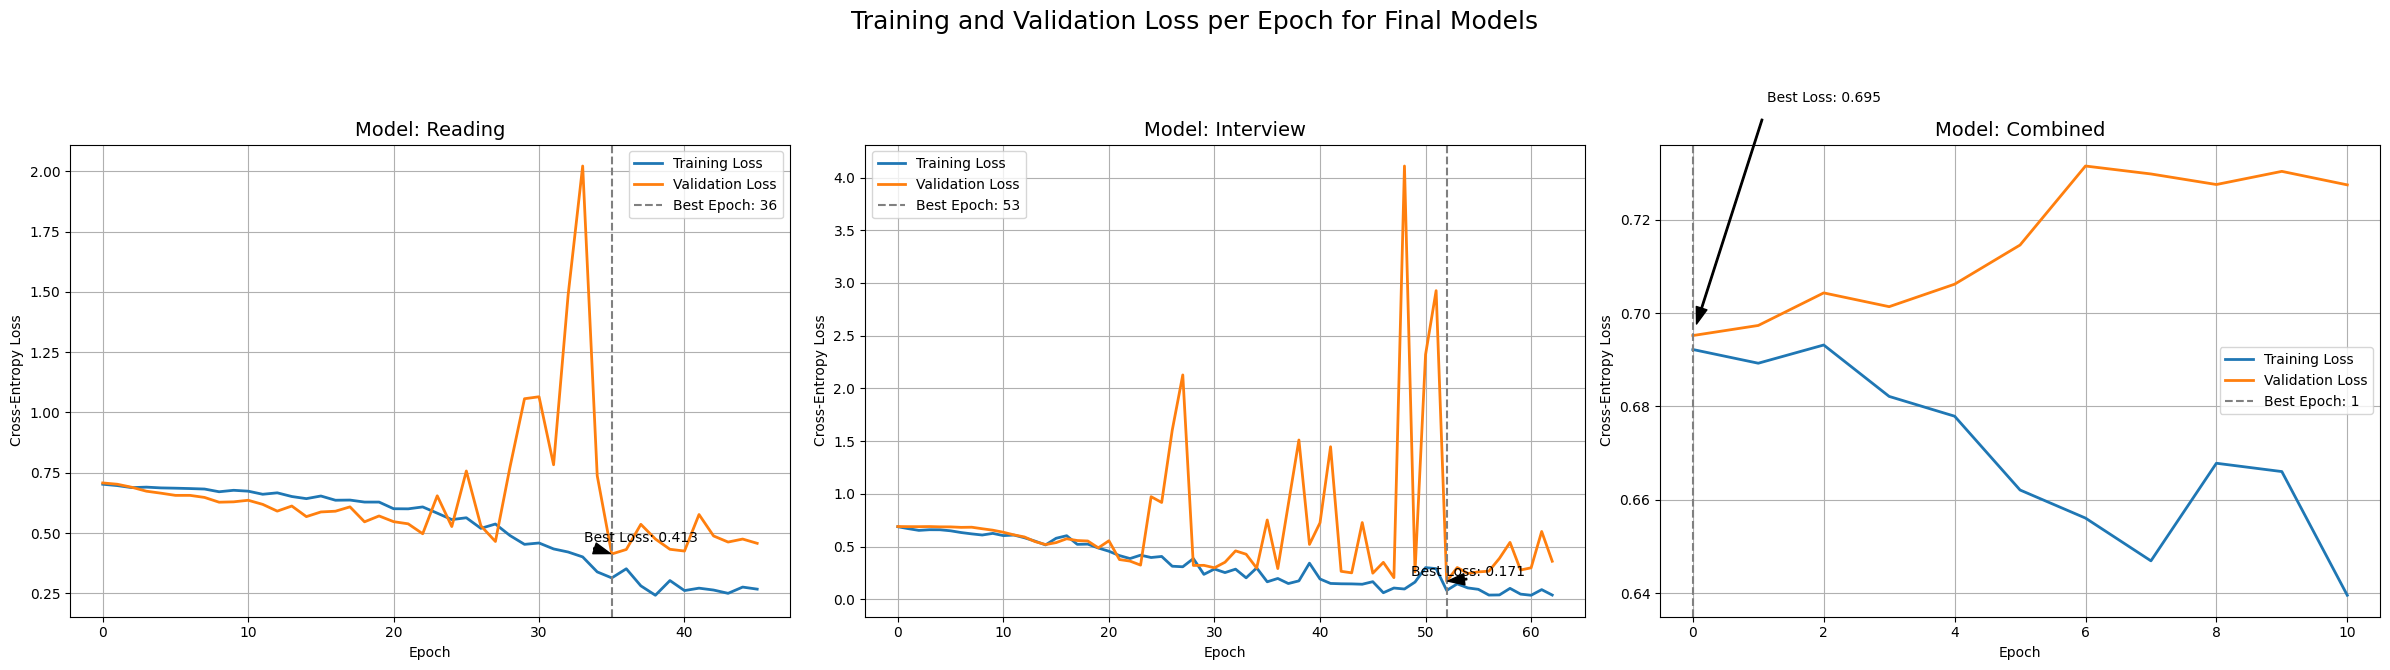

In [ ]:
import matplotlib.pyplot as plt
# Visualize Training and Validation Loss Curves from Saved Models

print("--- Generating Training/Validation Loss Curves for Final Models ---")

# Create a figure with 1 row and 3 columns for the side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=False)
fig.suptitle('Training and Validation Loss per Epoch for Final Models', fontsize=18)

# Loop through the three data types to find their saved models
for i, data_type in enumerate(['reading', 'interview', 'combined']):
    ax = axes[i]
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    # Load the history directly from the saved model file
    if os.path.exists(MODEL_SAVE_PATH):
        saved_data = torch.load(MODEL_SAVE_PATH)
        
        # Check if the history was saved in the file
        if 'train_loss_history' in saved_data and 'val_loss_history' in saved_data:
            train_history = saved_data['train_loss_history']
            val_history = saved_data['val_loss_history']
            
            # Plot the training and validation loss
            ax.plot(train_history, label='Training Loss', color='C0', lw=2)
            ax.plot(val_history, label='Validation Loss', color='C1', lw=2)
            
            # Find the epoch with the best validation loss to annotate the plot
            best_epoch = np.argmin(val_history)
            best_val_loss = np.min(val_history)
            
            # Add a vertical line and annotation to mark the best epoch
            ax.axvline(x=best_epoch, color='grey', linestyle='--', label=f'Best Epoch: {best_epoch + 1}')
            ax.annotate(f'Best Loss: {best_val_loss:.3f}', 
                        xy=(best_epoch, best_val_loss), 
                        xytext=(best_epoch + 2, best_val_loss + 0.05),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                        ha='center')
            
            ax.set_title(f'Model: {data_type.title()}', fontsize=14)
            ax.legend()
        else:
            ax.set_title(f'Model: {data_type.title()}\n(History not found in file)')
    else:
        ax.set_title(f'Model: {data_type.title()}\n(Model file not found)')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cross-Entropy Loss')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Load all experiment results into one dictionary

# Load the SVM results you generated in notebook 03
SVM_RESULTS_PATH = '../data/Processed_Features/all_svm_results.pkl' 
if os.path.exists(SVM_RESULTS_PATH):
    with open(SVM_RESULTS_PATH, 'rb') as f:
        all_results = pickle.load(f)
else:
    print("Warning: SVM results file not found. Final comparison will only show DL models.")
    all_results = {}

# The 'tuned_dl_results' dictionary already exists in this notebook's memory
# from the previous cell. Add contents to master dictionary.
all_results.update(tuned_dl_results)

print(f"Successfully loaded a total of {len(all_results)} experiment results for final comparison.")

# Create and Display Summary Table
final_summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    final_summary_data.append({
        'Experiment': experiment_name,
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
        'Mean Accuracy': results_df['accuracy'].mean(),
        'Std Dev Accuracy': results_df['accuracy'].std()
    })

final_summary_df = pd.DataFrame(final_summary_data).set_index('Experiment')

print("\n--- Final Comprehensive Results Summary ---")
display(final_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in final_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in final_summary_df.columns if 'Std Dev' in c], axis=0))

Successfully loaded a total of 3 experiment results for final comparison.

--- Final Comprehensive Results Summary ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
wav2vec2_cnn_lstm_tuned_reading,0.700233,0.098512,0.779298,0.052024,0.703557,0.100217
wav2vec2_cnn_lstm_tuned_interview,0.769940,0.106447,0.865358,0.096245,0.771429,0.105247
wav2vec2_cnn_lstm_tuned_combined,0.778985,0.085707,0.847107,0.092551,0.780952,0.085866
